# Food Identification

This is a demo showing how to constuct a convolutional neural network classifying foods.

### Here we import all the libraries we will be using.

In [120]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets
from tensorflow import keras
import numpy as np
from PIL import Image
from PIL import ImageFile
from PIL import ImageOps
import csv
import matplotlib.pyplot as plt
import os

In [72]:
# Constants

IMGSIZE = 32
classNames = ["Bread", "Dairy", "Dessert", "Egg", "Fried", "Meat", "Noodles", "Rice", "Seafood", "Soup", "Vegetable/Fruit"]
NUM_CLASSES = 11

### This is the function to load an image and return the image object.

In [56]:
def getImg(url, folder):
    im = Image.open("./" + folder + "/" + url, 'r')
    return im

## There are several options for how to "normalize" our inputs (the images). In order for the model to be able to train on the inputs, they have to have the same structure of features; in this case, we want all of our images to be the same size.  We will compare various ways to accomplish this, and the effectivness of each method.

### Method 1: Simply rescale the images. This is very simple and doesn't lose a lot of information, but may distort the images somewhat.

In [4]:
def resizeImg(im,save=False,folder=None,url=None):
    im = im.resize((IMGSIZE,IMGSIZE))
    if(save):
        destination = "./" + folder + "/" + url + ".png"
        im.save(destination, "PNG", quality=80, optimize=True, progressive=True)
    return im

### Method 2: Pad the images with black bars to normalize the ratios (make the images square), and then rescale. This has the added benefit of not distorting the images.

In [5]:
def padImg(im,save=False,folder=None,url=None):
    w, h = im.size
    padding = ((max(w,h) - w) // 2,
               (max(w,h) - h) // 2,
               (max(w,h) - w) - (max(w,h) - w) // 2,
               (max(w,h) - h) - (max(w,h) - h) // 2)
    im = ImageOps.expand(im, padding)
    im = im.resize((IMGSIZE, IMGSIZE))
    if(save):
        destination = "./" + folder + "/" + url + ".png"
        im.save(destination, "PNG", quality=80, optimize=True, progressive=True)
    return im

### Method 3: Crop the images into squares, and then rescale. This loses some information. However, in most of the images the food are in the center, and so cutting off the edges gets rid of extra information, and might actually be beneficial.

In [6]:
def cropImg(im,save=False,folder=None,url=None):
#     destination = "./"+folder+"ModifiedGrainy/"+url+".png"
    w, h = im.size
    im = im.crop(((w-min(w,h))//2, (h-min(w,h))//2, w - (w - min(w,h))//2,h - (h-min(w,h))//2))
    im = im.resize((IMGSIZE, IMGSIZE))
    if(save):
        destination = "./" + folder + "/" + url + ".png"
        im.save(destination, "PNG", quality=80, optimize=True, progressive=True)
    return im

### Optional addition: Greyscale? Reduce the amount of information the model has to learn from. But also lose a lot of potentially important information.

In [7]:
def greyScale(im,save=False,folder=None,url=None):
    im = im.convert('L')
    if(save):
        destination = "./" + folder + "/" + url + ".png"
        im.save(destination, "PNG", quality=80, optimize=True, progressive=True)
    return im

### Optional addition 2: Black/white? Reduces even further the amount of information the model has to learn from, and loses potentially even more important information.

In [8]:
def blackWhiteImg(im,save=False,folder=None,url=None):
    im = im.convert('1')
    if(save):
        destination = "./" + folder + "/" + url + ".png"
        im.save(destination, "PNG", quality=80, optimize=True, progressive=True)
    return im

# Here we load the images into arrays, so that we will be able to use them in our models.

### These arrays will each hold the modified versions of all the images. trainLabels and valLabels hold the ground truth of what each image is, what the model is trying to predict.

In [67]:
images = {}

trainLabels = []
valLabels = []

resizedImagesTrain = []
resizedImagesVal = []

blackWhiteImagesTrain = []
blackWhiteImagesVal = []

croppedImagesTrain = []
croppedImagesVal = []

greyscaleImagesTrain = []
greyscaleImagesVal = []

paddedImagesTrain = []
paddedImagesVal = []

### Here we loop through every image in the training, validation, and evaluation directories, and add them to the arrays.

#### Note: validation and training were combined in this instance in order to improve model accuracy. There are usually three sets of data in order to not overfit the parameters of the model.

In [86]:
filelist  = os.listdir("./training")

counter = 0
for filename in filelist:
    counter += 1
    img = getImg(filename, "training")
    if counter < 10:
        images[filename] = (img, filename.split("_")[0])
    trainLabels.append(int(filename.split("_")[0]))
    resizedImagesTrain.append(np.array(resizeImg(img)))
    paddedImagesTrain.append(np.array(padImg(img)))
    cropped = cropImg(img)
    croppedImagesTrain.append(np.array(cropped))
    greyscaleImagesTrain.append(np.array(greyScale(cropped)).reshape(IMGSIZE,IMGSIZE,1))
    blackWhiteImagesTrain.append(np.array(blackWhiteImg(cropped)).reshape(IMGSIZE,IMGSIZE,1))
    if counter % 100 == 0:
        print(counter)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800


In [87]:
filelist  = os.listdir("./validation")

counter = 0
for filename in filelist:
    counter += 1
    img = getImg(filename, "validation")
    trainLabels.append(int(filename.split("_")[0]))
    resizedImagesTrain.append(np.array(resizeImg(img)))
    paddedImagesTrain.append(np.array(padImg(img)))
    cropped = cropImg(img)
    croppedImagesTrain.append(np.array(cropped))
    greyscaleImagesTrain.append(np.array(greyScale(cropped)).reshape(IMGSIZE,IMGSIZE,1))
    blackWhiteImagesTrain.append(np.array(blackWhiteImg(cropped)).reshape(IMGSIZE,IMGSIZE,1))
    if counter % 100 == 0:
        print(counter)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400


In [88]:
filelist  = os.listdir("./evaluation")

counter = 0
for filename in filelist:
    counter += 1
    img = getImg(filename, "evaluation")
    valLabels.append(int(filename.split("_")[0]))
    resizedImagesVal.append(np.array(resizeImg(img)))
    paddedImagesVal.append(np.array(padImg(img)))
    cropped = cropImg(img)
    croppedImagesVal.append(np.array(cropped))
    greyscaleImagesVal.append(np.array(greyScale(cropped)).reshape(IMGSIZE,IMGSIZE,1))
    blackWhiteImagesVal.append(np.array(blackWhiteImg(cropped)).reshape(IMGSIZE,IMGSIZE,1))
    if counter % 100 == 0:
        print(counter)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300


### The arrays need to be converted into numpy arrays. This is a library which is very useful when dealing with vectors/matrices, and is the necessary input for TensorFlow.

In [74]:
trainLabelsNum = np.array([np.array([label]) for label in trainLabels])
valLabelsNum = np.array([np.array([label]) for label in valLabels])

resizedImagesTrain = np.array(resizedImagesTrain)
resizedImagesVal = np.array(resizedImagesVal)

blackWhiteImagesTrain = np.array(blackWhiteImagesTrain)
blackWhiteImagesVal = np.array(blackWhiteImagesVal)

croppedImagesTrain = np.array(croppedImagesTrain)
croppedImagesVal = np.array(croppedImagesVal)

greyscaleImagesTrain = np.array(greyscaleImagesTrain)
greyscaleImagesVal = np.array(greyscaleImagesVal)

paddedImagesTrain = np.array(paddedImagesTrain)
paddedImagesVal = np.array(paddedImagesVal)

### Original images.

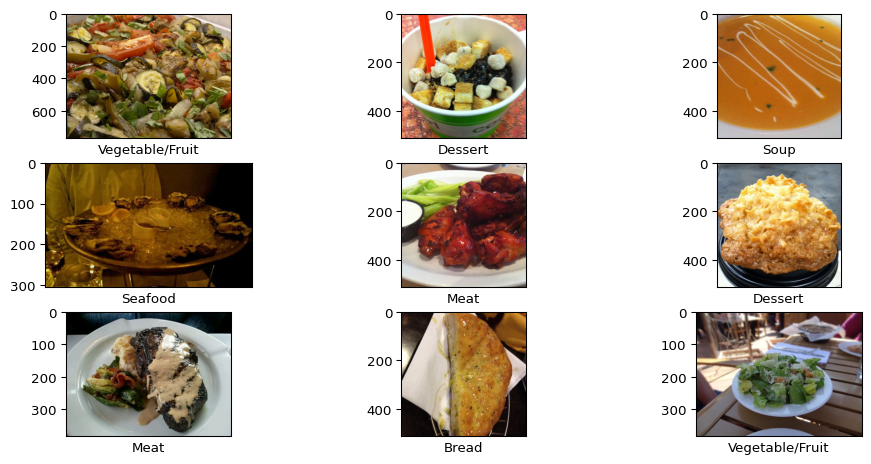

In [111]:
plt.figure(figsize=(12, 12), dpi=96)

imageNum = 1
for key, value in images.items():
    img, label = value
    plt.subplot(6,3,imageNum)
    plt.imshow(np.asarray(img))
    plt.xlabel(classNames[int(label)])
    plt.xticks([])
    imageNum += 1

### Squared (resized) images.

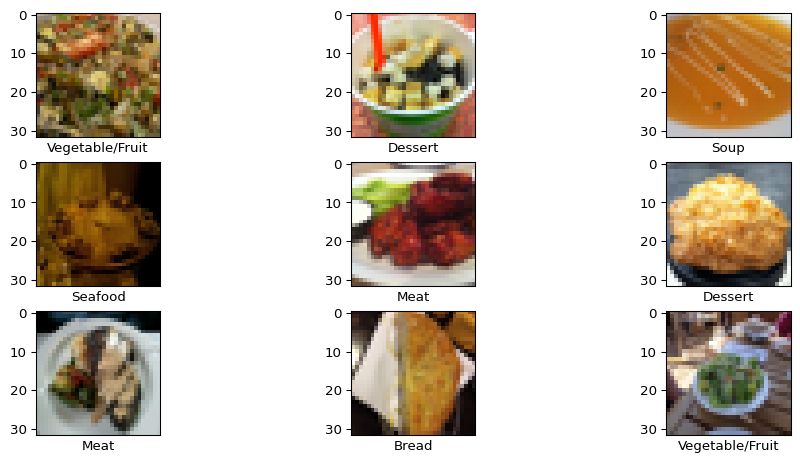

In [112]:
plt.figure(figsize=(12, 12), dpi=96)

for i in range(9):
    img = resizedImagesTrain[i]
    plt.subplot(6,3,i+1)
    plt.imshow(img)
    plt.xlabel(classNames[int(trainLabels[i])])
    plt.xticks([])

### Padded images.

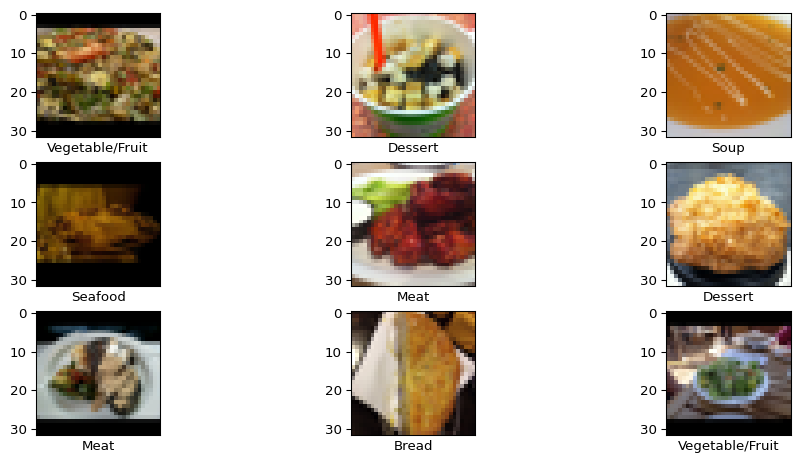

In [113]:
plt.figure(figsize=(12, 12), dpi=96)

for i in range(9):
    img = paddedImagesTrain[i]
    plt.subplot(6,3,i+1)
    plt.imshow(img)
    plt.xlabel(classNames[int(trainLabels[i])])
    plt.xticks([])

### Cropped images.

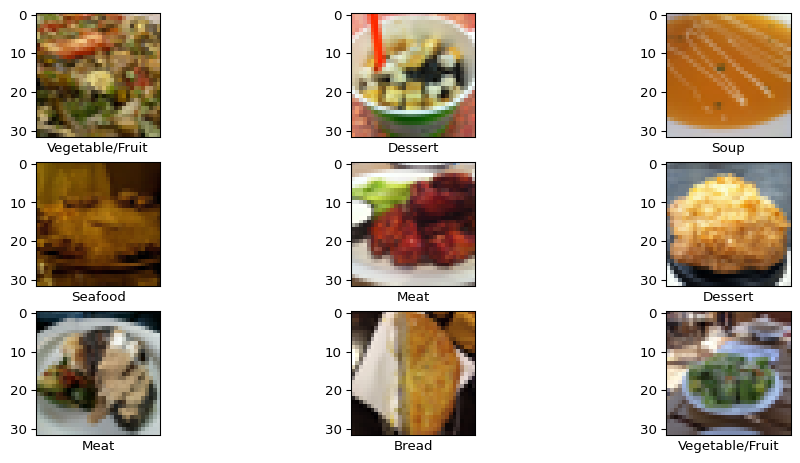

In [114]:
plt.figure(figsize=(12, 12), dpi=96)

for i in range(9):
    img = croppedImagesTrain[i]
    plt.subplot(6,3,i+1)
    plt.imshow(img)
    plt.xlabel(classNames[int(trainLabels[i])])
    plt.xticks([])

### Greyscale images.

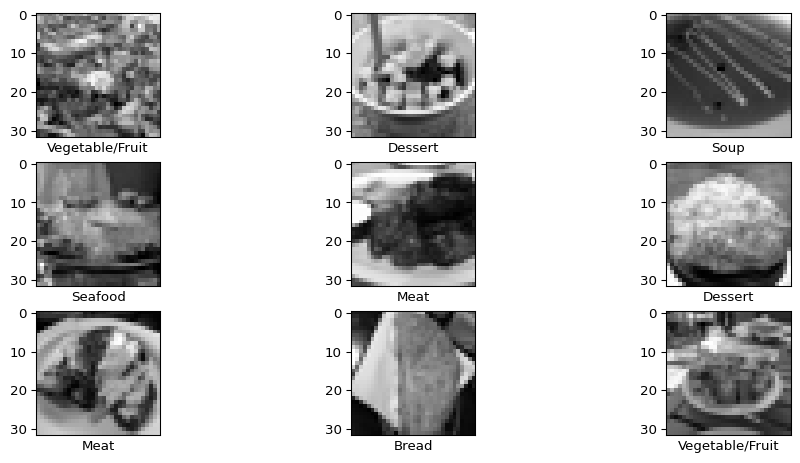

In [115]:
plt.figure(figsize=(12, 12), dpi=96)

for i in range(9):
    img = greyscaleImagesTrain[i]
    plt.subplot(6,3,i+1)
    plt.imshow(img.reshape(IMGSIZE, IMGSIZE), cmap='gray')
    plt.xlabel(classNames[int(trainLabels[i])])
    plt.xticks([])

### Black/white images.

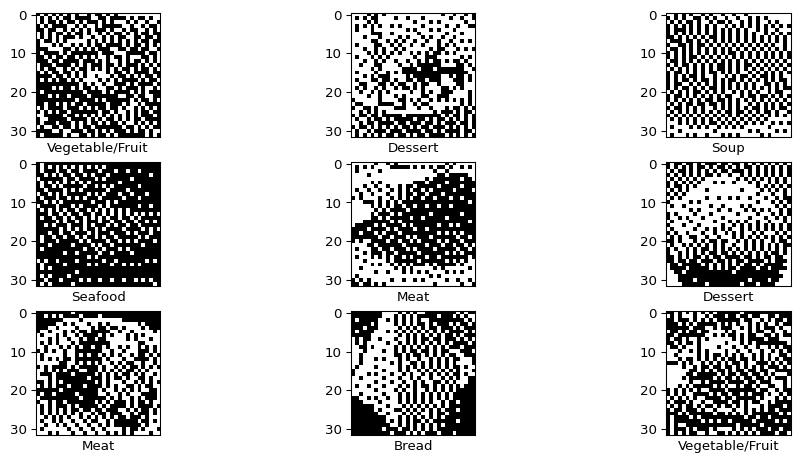

In [116]:
plt.figure(figsize=(12, 12), dpi=96)

for i in range(9):
    img = blackWhiteImagesTrain[i]
    plt.subplot(6,3,i+1)
    plt.imshow(img.reshape(IMGSIZE, IMGSIZE), cmap='gray')
    plt.xlabel(classNames[trainLabels[i]])
    plt.xticks([])

# Now for the actual model building part:

## We will show several configurations of the model, and compare what works and what doesn't. Some parameters that can be messed with:

* Learning rate
* Number / width of layers

In [181]:
def modelTrain(trainImgs, valImgs, layer1, layer2, layer3, layer4, dim, epochs, learningRate=.01):
    trainImgs, valImgs = trainImgs / 255.0, valImgs / 255.0
    model = Sequential([
        Conv2D(layer1, 3, padding='same', activation='relu', input_shape=(IMGSIZE,IMGSIZE,dim)),
        MaxPooling2D(),
        Conv2D(layer2, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(layer3, 3, padding='same', activation='relu'),
        Flatten(),
        Dense(layer4, activation='relu'),
        Dense(NUM_CLASSES)
    ])
    opt = keras.optimizers.Adam(learning_rate=learningRate)
    model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    total_train = len(trainImgs)
    total_val = len(valImgs)

    history = model.fit(
        trainImgs,
        trainLabelsNum,
        epochs=epochs,
        validation_data=(valImgs, valLabelsNum)
    )
    return history, model

In [31]:
def plotHistory(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0,1])
    plt.legend(loc='upper left')

In [145]:
def plotPredictions(model, test_images, num=25):
    predictions = model.predict(test_images)
    plt.figure(figsize=(20,20))
    for i in range(num):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(test_images[i], cmap=plt.cm.binary)
        
        predictions_logits = predictions[i]
        predictions_probabilities = tf.nn.softmax(predictions_logits).numpy().tolist()
        max_idx = predictions_probabilities.index(max(predictions_probabilities))
        prob = round(predictions_probabilities[max_idx], 1)
        predicted_class = classNames[max_idx]
        
        plt.xlabel(predicted_class + ' (' + str(prob) + ')')
    plt.show()

In [90]:
history, model = modelTrain(greyscaleImagesTrain, greyscaleImagesVal, 32, 32, 32, 64, 1, 20)

Epoch 1/20
416/416 [==============================] - 10s 24ms/step - loss: 2.1829 - accuracy: 0.2211 - val_loss: 2.0375 - val_accuracy: 0.2788
Epoch 2/20
416/416 [==============================] - 11s 26ms/step - loss: 1.9821 - accuracy: 0.3011 - val_loss: 1.9313 - val_accuracy: 0.3293
Epoch 3/20
416/416 [==============================] - 12s 28ms/step - loss: 1.8694 - accuracy: 0.3422 - val_loss: 1.8273 - val_accuracy: 0.3654
Epoch 4/20
416/416 [==============================] - 11s 26ms/step - loss: 1.7872 - accuracy: 0.3771 - val_loss: 1.7771 - val_accuracy: 0.3759
Epoch 5/20
416/416 [==============================] - 11s 27ms/step - loss: 1.7150 - accuracy: 0.3967 - val_loss: 1.7329 - val_accuracy: 0.3884
Epoch 6/20
416/416 [==============================] - 11s 26ms/step - loss: 1.6537 - accuracy: 0.4211 - val_loss: 1.7135 - val_accuracy: 0.3962
Epoch 7/20
416/416 [==============================] - 11s 27ms/step - loss: 1.5870 - accuracy: 0.4474 - val_loss: 1.7224 - val_accuracy:

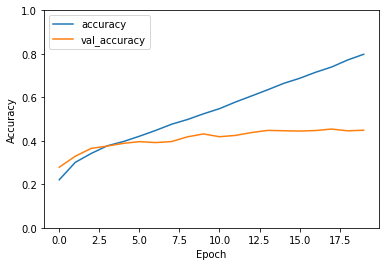

In [91]:
plotHistory(history)

In [174]:
history, model = modelTrain(croppedImagesTrain, croppedImagesVal, 32, 32, 32, 64, 3, 20)

Epoch 1/20
416/416 [==============================] - 12s 28ms/step - loss: 2.1139 - accuracy: 0.2496 - val_loss: 1.9198 - val_accuracy: 0.3424
Epoch 2/20
416/416 [==============================] - 13s 31ms/step - loss: 1.8136 - accuracy: 0.3669 - val_loss: 1.7567 - val_accuracy: 0.3830
Epoch 3/20
416/416 [==============================] - 13s 32ms/step - loss: 1.6515 - accuracy: 0.4216 - val_loss: 1.6419 - val_accuracy: 0.4219
Epoch 4/20
416/416 [==============================] - 13s 32ms/step - loss: 1.5522 - accuracy: 0.4566 - val_loss: 1.5195 - val_accuracy: 0.4786
Epoch 5/20
416/416 [==============================] - 13s 31ms/step - loss: 1.4523 - accuracy: 0.4953 - val_loss: 1.5135 - val_accuracy: 0.4667
Epoch 6/20
416/416 [==============================] - 13s 32ms/step - loss: 1.3776 - accuracy: 0.5235 - val_loss: 1.5009 - val_accuracy: 0.4724
Epoch 7/20
416/416 [==============================] - 13s 30ms/step - loss: 1.2882 - accuracy: 0.5545 - val_loss: 1.4996 - val_accuracy:

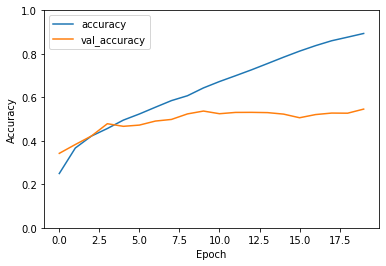

In [175]:
plotHistory(history)

In [179]:
history, model = modelTrain(paddedImagesTrain, paddedImagesVal, 32, 32, 32, 64, 3, 20)

Epoch 1/20
416/416 [==============================] - 13s 32ms/step - loss: 2.1022 - accuracy: 0.2543 - val_loss: 2.0464 - val_accuracy: 0.2976
Epoch 2/20
416/416 [==============================] - 13s 32ms/step - loss: 1.8091 - accuracy: 0.3660 - val_loss: 1.7661 - val_accuracy: 0.3908
Epoch 3/20
416/416 [==============================] - 13s 30ms/step - loss: 1.6594 - accuracy: 0.4262 - val_loss: 1.6518 - val_accuracy: 0.4296
Epoch 4/20
416/416 [==============================] - 13s 31ms/step - loss: 1.5382 - accuracy: 0.4666 - val_loss: 1.5613 - val_accuracy: 0.4646
Epoch 5/20
416/416 [==============================] - 14s 33ms/step - loss: 1.4406 - accuracy: 0.5008 - val_loss: 1.5247 - val_accuracy: 0.4837
Epoch 6/20
416/416 [==============================] - 13s 31ms/step - loss: 1.3514 - accuracy: 0.5269 - val_loss: 1.5325 - val_accuracy: 0.4885
Epoch 7/20
416/416 [==============================] - 13s 31ms/step - loss: 1.2594 - accuracy: 0.5628 - val_loss: 1.4809 - val_accuracy:

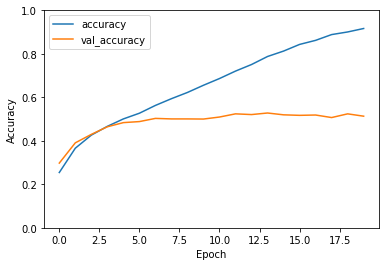

In [180]:
plotHistory(history)

In [177]:
history, model = modelTrain(blackWhiteImagesTrain, blackWhiteImagesVal, 32, 32, 32, 64, 1, 20)

Epoch 1/20
416/416 [==============================] - 12s 29ms/step - loss: 2.3040 - accuracy: 0.1526 - val_loss: 2.3001 - val_accuracy: 0.1494
Epoch 2/20
416/416 [==============================] - 13s 32ms/step - loss: 2.2978 - accuracy: 0.1449 - val_loss: 2.2975 - val_accuracy: 0.1494
Epoch 3/20
416/416 [==============================] - 16s 39ms/step - loss: 2.2965 - accuracy: 0.1490 - val_loss: 2.2988 - val_accuracy: 0.1494
Epoch 4/20
416/416 [==============================] - 15s 36ms/step - loss: 2.2961 - accuracy: 0.1511 - val_loss: 2.2983 - val_accuracy: 0.1494
Epoch 5/20
416/416 [==============================] - 12s 29ms/step - loss: 2.2964 - accuracy: 0.1498 - val_loss: 2.2998 - val_accuracy: 0.1494
Epoch 6/20
416/416 [==============================] - 12s 29ms/step - loss: 2.2961 - accuracy: 0.1482 - val_loss: 2.2969 - val_accuracy: 0.1494
Epoch 7/20
416/416 [==============================] - 12s 30ms/step - loss: 2.2958 - accuracy: 0.1452 - val_loss: 2.2967 - val_accuracy:

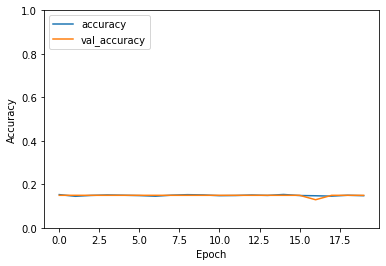

In [178]:
plotHistory(history)

In [185]:
history, model = modelTrain(resizedImagesTrain, resizedImagesVal, 32, 32, 32, 64, 3, 20)

Epoch 1/20
416/416 [==============================] - 10s 24ms/step - loss: 2.3033 - accuracy: 0.1530 - val_loss: 2.2973 - val_accuracy: 0.1494
Epoch 2/20
416/416 [==============================] - 11s 26ms/step - loss: 2.2971 - accuracy: 0.1490 - val_loss: 2.2974 - val_accuracy: 0.1494
Epoch 3/20
416/416 [==============================] - 12s 29ms/step - loss: 2.2955 - accuracy: 0.1502 - val_loss: 2.2976 - val_accuracy: 0.1494
Epoch 4/20
101/416 [======>.......................] - ETA: 8s - loss: 2.3011 - accuracy: 0.1433

KeyboardInterrupt: 

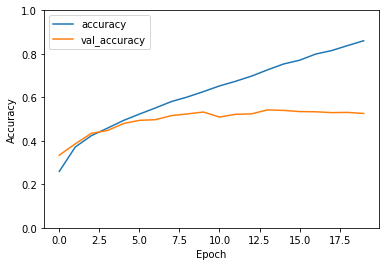

In [93]:
plotHistory(history)

In [184]:
history, model = modelTrain(resizedImagesTrain, resizedImagesVal, 32, 32, 32, 64, 3, 20, 10)

Epoch 1/20
416/416 [==============================] - 12s 29ms/step - loss: 45522087936.0000 - accuracy: 0.1132 - val_loss: 3.6028 - val_accuracy: 0.1494
Epoch 2/20
416/416 [==============================] - 12s 28ms/step - loss: 3.2036 - accuracy: 0.1142 - val_loss: 3.1797 - val_accuracy: 0.1001
Epoch 3/20
416/416 [==============================] - 12s 28ms/step - loss: 3.2312 - accuracy: 0.1206 - val_loss: 3.3883 - val_accuracy: 0.1494
Epoch 4/20
416/416 [==============================] - 12s 29ms/step - loss: 3.4804 - accuracy: 0.1148 - val_loss: 3.2913 - val_accuracy: 0.0442
Epoch 5/20
416/416 [==============================] - 12s 28ms/step - loss: 3.2710 - accuracy: 0.1163 - val_loss: 2.8377 - val_accuracy: 0.1494
Epoch 6/20
416/416 [==============================] - 12s 30ms/step - loss: 3.2019 - accuracy: 0.1127 - val_loss: 3.0522 - val_accuracy: 0.1494
Epoch 7/20
416/416 [==============================] - 12s 30ms/step - loss: 3.1421 - accuracy: 0.1144 - val_loss: 3.5172 - val

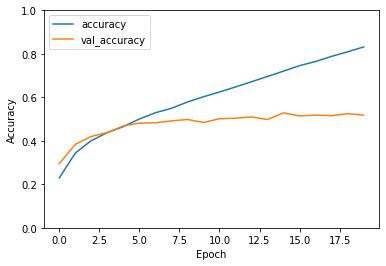

In [156]:
plotHistory(history)

In [182]:
history, model = modelTrain(resizedImagesTrain, resizedImagesVal, 32, 32, 32, 64, 3, 20, .000001)

Epoch 1/20
416/416 [==============================] - 11s 27ms/step - loss: 2.3956 - accuracy: 0.1096 - val_loss: 2.3896 - val_accuracy: 0.1225
Epoch 2/20
416/416 [==============================] - 12s 29ms/step - loss: 2.3827 - accuracy: 0.1443 - val_loss: 2.3757 - val_accuracy: 0.1413
Epoch 3/20
416/416 [==============================] - 12s 29ms/step - loss: 2.3673 - accuracy: 0.1533 - val_loss: 2.3598 - val_accuracy: 0.1446
Epoch 4/20
416/416 [==============================] - 12s 29ms/step - loss: 2.3515 - accuracy: 0.1482 - val_loss: 2.3449 - val_accuracy: 0.1416
Epoch 5/20
416/416 [==============================] - 12s 29ms/step - loss: 2.3378 - accuracy: 0.1472 - val_loss: 2.3326 - val_accuracy: 0.1395
Epoch 6/20
416/416 [==============================] - 12s 30ms/step - loss: 2.3268 - accuracy: 0.1474 - val_loss: 2.3232 - val_accuracy: 0.1365
Epoch 7/20
416/416 [==============================] - 11s 26ms/step - loss: 2.3185 - accuracy: 0.1492 - val_loss: 2.3161 - val_accuracy:

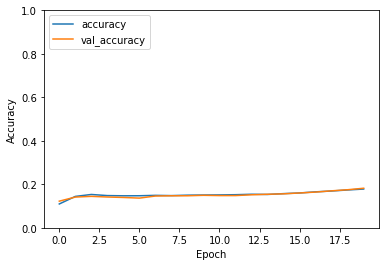

In [183]:
plotHistory(history)

In [97]:
history, model = modelTrain(resizedImagesTrain, resizedImagesVal, 32, 16, 16, 32, 3, 20)

Epoch 1/20
416/416 [==============================] - 8s 18ms/step - loss: 2.2174 - accuracy: 0.2006 - val_loss: 2.0859 - val_accuracy: 0.2788
Epoch 2/20
416/416 [==============================] - 8s 19ms/step - loss: 2.0255 - accuracy: 0.2869 - val_loss: 1.9798 - val_accuracy: 0.3059
Epoch 3/20
416/416 [==============================] - 8s 19ms/step - loss: 1.8850 - accuracy: 0.3436 - val_loss: 1.7817 - val_accuracy: 0.3803
Epoch 4/20
416/416 [==============================] - 8s 20ms/step - loss: 1.7587 - accuracy: 0.3865 - val_loss: 1.7422 - val_accuracy: 0.3869
Epoch 5/20
416/416 [==============================] - 8s 20ms/step - loss: 1.6843 - accuracy: 0.4151 - val_loss: 1.7007 - val_accuracy: 0.3941
Epoch 6/20
416/416 [==============================] - 8s 20ms/step - loss: 1.6165 - accuracy: 0.4377 - val_loss: 1.6722 - val_accuracy: 0.4150
Epoch 7/20
416/416 [==============================] - 9s 21ms/step - loss: 1.5599 - accuracy: 0.4601 - val_loss: 1.6028 - val_accuracy: 0.4350

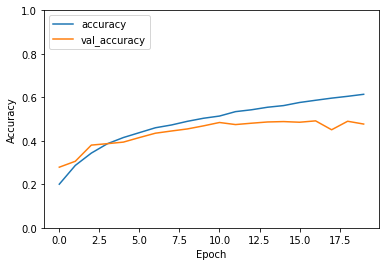

In [100]:
plotHistory(history)

In [125]:
history, model = modelTrain(resizedImagesTrain, resizedImagesVal, 32, 8, 8, 16, 3, 20)

Epoch 1/20
416/416 [==============================] - 9s 22ms/step - loss: 2.2565 - accuracy: 0.1791 - val_loss: 2.1809 - val_accuracy: 0.2088
Epoch 2/20
416/416 [==============================] - 9s 22ms/step - loss: 2.1433 - accuracy: 0.2232 - val_loss: 2.1111 - val_accuracy: 0.2528
Epoch 3/20
416/416 [==============================] - 9s 21ms/step - loss: 2.0766 - accuracy: 0.2543 - val_loss: 2.0549 - val_accuracy: 0.2740
Epoch 4/20
416/416 [==============================] - 9s 21ms/step - loss: 2.0179 - accuracy: 0.2849 - val_loss: 2.0290 - val_accuracy: 0.2886
Epoch 5/20
416/416 [==============================] - 10s 23ms/step - loss: 1.9601 - accuracy: 0.3124 - val_loss: 1.9270 - val_accuracy: 0.3257
Epoch 6/20
416/416 [==============================] - 10s 23ms/step - loss: 1.8977 - accuracy: 0.3369 - val_loss: 1.8702 - val_accuracy: 0.3532
Epoch 7/20
416/416 [==============================] - 10s 24ms/step - loss: 1.8467 - accuracy: 0.3454 - val_loss: 1.8132 - val_accuracy: 0.3

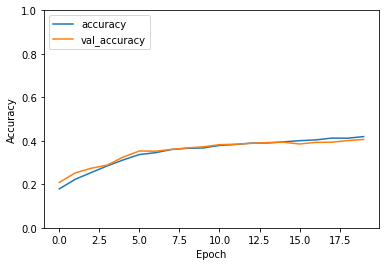

In [126]:
plotHistory(history)

### Here we can see some of the predictions the model is making, as well as the probabilities.

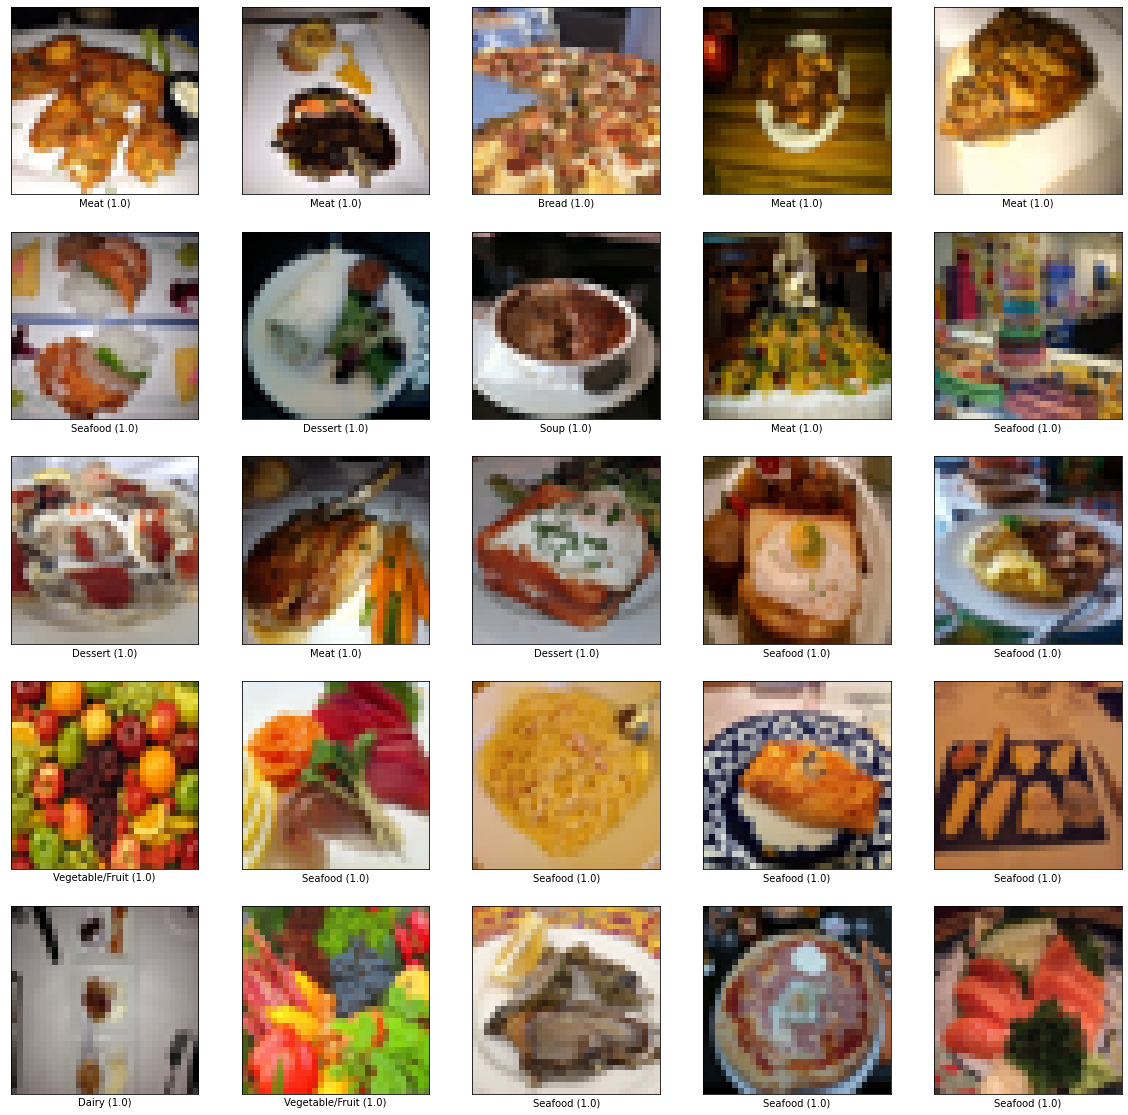

In [105]:
plotPredictions(model, resizedImagesVal)

### Now what happens if we make the model predict on images which can't be labelled by the given classes?

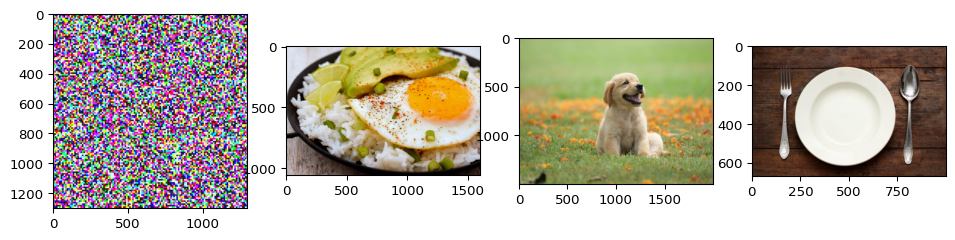

In [169]:
randImgs = []
plt.figure(figsize=(12, 12), dpi=96)

filelist  = os.listdir("./randImgs")

counter = 1
for filename in filelist:
    if filename.startswith("."):
        continue
    img = getImg(filename, "randImgs")
    randImgs.append(np.array(resizeImg(img)))
    plt.subplot(1,4,counter)
    plt.imshow(np.array(img))
    counter += 1

(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


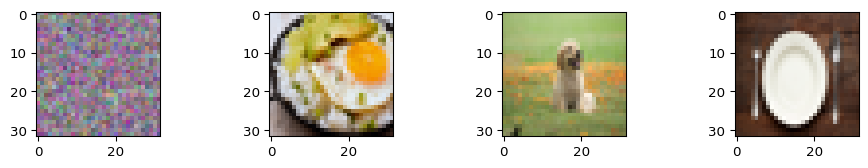

In [170]:
plt.figure(figsize=(12, 12), dpi=96)

for i in range(4):
    img = randImgs[i]
    print(img.shape)
    plt.subplot(6,4,i+1)
    plt.imshow(img)

In [171]:
randImgs = np.array(randImgs)

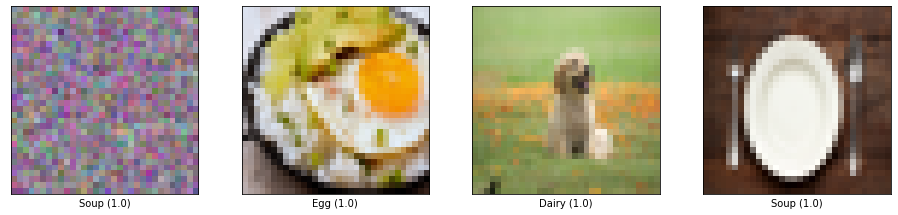

In [173]:
plotPredictions(model, randImgs, 4)